In [69]:
%load_ext autoreload
%autoreload 2

In [34]:
import cv2
import torch
import torchvision

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from tqdm.cli import tqdm
from pathlib import Path
from sklearn.model_selection import StratifiedKFold

In [41]:
data_folder = Path("data")
folds_folder = Path("folds")

In [45]:
def create_dataframes(data_folder):
    df = pd.DataFrame()
    for seq_folder in tqdm(list(data_folder.glob("S_*"))):
        seq_name = seq_folder.name
        seq_num = int(seq_name.split("_")[-1])

        for img_fn in seq_folder.glob("*.png"):
            img_num = int(img_fn.stem)

            img_info = {
                "seq": seq_num,
                "order": img_num,
                "img_filename": img_fn,
            }

            mask_fn = seq_folder / f"label_{img_num}.npy"
            if mask_fn.exists():
                img_info["mask_filename"] = mask_fn
            df = df.append(img_info, ignore_index=True)

    df = df.sort_values(by=["seq", "order"])
    train_df = df[df.mask_filename.notna()]
    test_df = df[df.mask_filename.isna()]
    
    return train_df, test_df

train_df, test_df = create_dataframes(data_folder)
train_df.to_csv(data_folder / "train.csv", index=False)
test_df.to_csv(data_folder / "test.csv", index=False)

100%|██████████| 200/200 [01:38<00:00,  2.02it/s]


In [48]:
def stratified_k_fold(
    description, 
    n_folds,
    stratified_by,
    random_state=42
):
    folds = []
    
    X = description
    y = description[stratified_by]
    
    stratifier = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    for _, test_indexes in stratifier.split(X, y):
        folds.append(X.iloc[test_indexes])
            

    folds = [pd.DataFrame(fold, columns=description.columns) for fold in folds]
    return folds

In [49]:
folds = stratified_k_fold(train_df, 4, "seq")

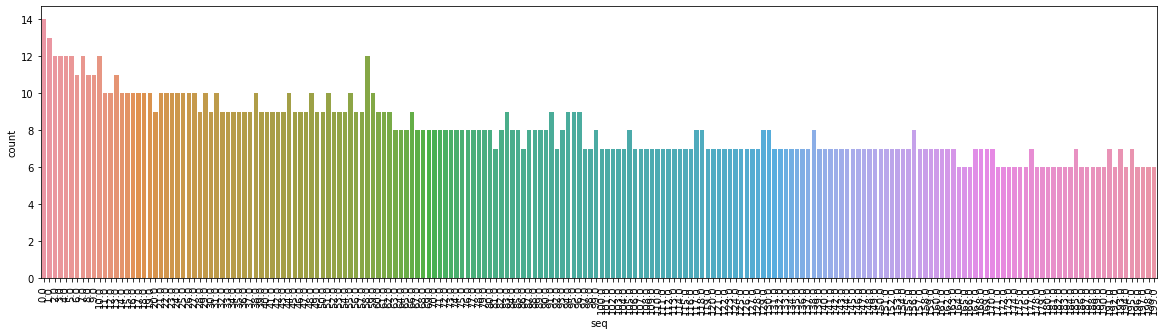

In [50]:
plt.figure(figsize=(20, 5))
plt.xticks(rotation='vertical')
sns.countplot(train_df.seq)

In [51]:
folds_folder = Path("folds")

for idx, fold in enumerate(folds):
    fold_filename =  folds_folder / f"fold_{idx}.csv"
    fold.to_csv(fold_filename, index=False)

In [59]:
def load_splits(folds_folder, val_folds=[0], train_folds=None):
    folds = [int(fn.stem.split('_')[-1]) for fn in folds_folder.glob("fold_?.csv")]
    
    if train_folds is None:
        train_folds = [f for f in folds if f not in val_folds]
        
    if val_folds is None:
        train_folds = [f for f in folds if f not in train_folds]
        
    val = pd.concat([pd.read_csv(folds_folder / f"fold_{fi}.csv") for fi in val_folds])
    train = pd.concat([pd.read_csv(folds_folder / f"fold_{fi}.csv") for fi in train_folds])
    val = val.reset_index()
    train = train.reset_index()
    return train, val

In [60]:
tr_df, val_df = load_splits(folds_folder)


In [68]:
tr_df.shape, val_df.shape

((1203, 5), (402, 5))

In [55]:
tr_df[tr_df.seq == 0]

,index,img_filename,order,seq,mask_filename
0,0,data/S_0/23.png,23.0,0.0,data/S_0/label_23.npy
1,1,data/S_0/41.png,41.0,0.0,data/S_0/label_41.npy
2,2,data/S_0/102.png,102.0,0.0,data/S_0/label_102.npy
401,0,data/S_0/42.png,42.0,0.0,data/S_0/label_42.npy
402,1,data/S_0/108.png,108.0,0.0,data/S_0/label_108.npy
403,2,data/S_0/120.png,120.0,0.0,data/S_0/label_120.npy
404,3,data/S_0/149.png,149.0,0.0,data/S_0/label_149.npy
802,0,data/S_0/21.png,21.0,0.0,data/S_0/label_21.npy
803,1,data/S_0/53.png,53.0,0.0,data/S_0/label_53.npy
804,2,data/S_0/132.png,132.0,0.0,data/S_0/label_132.npy


In [65]:
val_df[val_df.seq == 0]

,index,img_filename,order,seq,mask_filename
0,0,data/S_0/39.png,39.0,0.0,data/S_0/label_39.npy
1,1,data/S_0/86.png,86.0,0.0,data/S_0/label_86.npy
2,2,data/S_0/91.png,91.0,0.0,data/S_0/label_91.npy
3,3,data/S_0/137.png,137.0,0.0,data/S_0/label_137.npy
